In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import json
import lightgbm as lgb

from pandas import datetime
import math
import re
import time
import random
import os
import pickle
import joblib

from pandas.tseries.offsets import *
from operator import *

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

from IPython.display import Image

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [ ]:
seed = 21 #Setting seed.

df_train = pd.read_csv('/content/drive/My Drive/Rossmann Sales Forecasting/df_weather_no_zeros', parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_submit = pd.read_csv('/content/drive/My Drive/Rossmann Sales Forecasting/df_submit_with_weather_no_zeros')

In [ ]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'SalesLog', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'State', 'Year', 'Month', 'Day', 'WeekOfYear',
       'DayOfYear', 'holidays_this_week', 'holidays_last_week',
       'holidays_next_week', 'State_holiday_before_days',
       'State_holiday_after_days', 'Promo_before_days', 'Promo_after_days',
       'School_holiday_before_days', 'School_holiday_after_days',
       'Dummy_close', 'SalesPerDay', 'Customers_per_day',
       'Sales_Per_Customers_Per_Day', 'CompetitionOpen ', 'PromoOpen',
       'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3',
       'Variation', 'Acceleration', 'Weekly_rolling_mean',
       'Monthly_rolling_mean', 'Previous_quarter_median',
       'Previous_half_year_median', 'Median_over_day_of_week',
       'Pr

In [ ]:
#Defining metric.
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return "rmspe", rmspe

scorer = make_scorer(rmspe, greater_is_better=False)

In [ ]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,State,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days,Promo_before_days,Promo_after_days,School_holiday_before_days,School_holiday_after_days,Dummy_close,SalesPerDay,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,353,2,2013-01-01,3139,1,0,a,1,8.051978,b,b,900.0,NaN,NaN,1,14.0,2013.0,BW,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,5651.368817,1451.086022,3.894579,NaN,-3.25,2.0,5.0,8.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,5514.0,5805.5,5805.5,-0.001082,0.428571,362259.254095,272789.258298,8,3,-2,3,1,-3,93,80,51,1016,1011,1008,31.0,12.0,10.0,23,6,0.25,6.0,Fog-Rain,228
1,423,2,2013-01-01,9643,1,0,a,1,9.174091,b,a,1270.0,5.0,2014.0,0,NaN,NaN,BE,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,10828.403397,1886.130573,5.741068,-16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10195.0,11338.0,11338.0,-0.429487,0.286325,391277.072069,371198.715249,8,7,5,6,3,2,100,78,62,1009,1004,1003,31.0,14.0,10.0,26,18,0.76,6.0,Rain,216
2,948,2,2013-01-01,4491,1,0,a,1,8.410053,b,b,1430.0,NaN,NaN,0,NaN,NaN,BW,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,6944.243797,1714.269687,4.050847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6523.0,7069.0,7069.0,-0.001089,0.005447,388730.629793,316539.642562,8,3,-2,3,1,-3,93,80,51,1016,1011,1008,31.0,12.0,10.0,23,6,0.25,6.0,Fog-Rain,228
3,274,2,2013-01-01,3102,1,0,a,1,8.040125,b,b,3640.0,NaN,NaN,1,10.0,2013.0,HE,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,4070.828326,992.741416,4.100593,NaN,-2.25,1.0,4.0,7.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,3339.0,3678.5,3678.5,-0.006039,0.150966,114251.813759,84539.855512,8,6,3,6,3,1,93,80,59,1015,1008,1006,31.0,12.0,10.0,23,14,2.03,6.0,Rain,206
4,1097,2,2013-01-01,5961,1,0,a,1,8.693161,b,b,720.0,3.0,2002.0,0,NaN,NaN,RP,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,9744.599788,2420.921444,4.025161,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9443.0,10222.0,10222.0,0.005353,-0.001071,305651.203930,276546.292577,8,6,4,7,3,1,92,75,59,1015,1010,1008,31.0,19.0,5.0,26,19,0.25,8.0,Rain,-1


In [ ]:
df_train.sort_values('Date', inplace=True)

# Preprocessing Data.

*Note: Some collinear features are kept to understand their effect on models.

In [ ]:
#Removing some features based on VIF analysis done in feature engineering notebook.
df_1 = df_train.drop(['Date'], axis=1)

In [ ]:
df_submit = df_submit.rename(columns={'Sales_per_day':'SalesPerDay'})

In [ ]:
for i in df_submit.columns:
    if i not in df_1.columns:
        print(i)

Id
Max_Gust_SpeedKm_h


In [ ]:
for i in df_1.columns:
    if i not in df_submit.columns:
        print(i)

Sales
SalesLog
Monthly_rolling_mean
Promo_median_sales
Holiday_median_sales


In [ ]:
df_submit.drop(['Max_Gust_SpeedKm_h'], axis=1, inplace=True)
df_1.drop(['Monthly_rolling_mean','Promo_median_sales','Holiday_median_sales'], axis=1, inplace=True)

In [ ]:
df_1[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']] = df_1[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']].fillna(-1)

df_submit[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']] = df_submit[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']].fillna(-1)

In [ ]:
df_1['StateHoliday'].replace(0, '0', inplace=True)
df_submit['StateHoliday'].replace(0, '0', inplace=True)

In [ ]:
X = df_1.drop(['SalesLog','Sales'], axis=1)
y = df_1['Sales']

In [ ]:
X.drop(['Open'], axis=1, inplace=True)

In [ ]:
#Some Test ids where Open will be equal to zero.
b = [480, 1336, 2192, 3048, 4760, 5616, 6472, 7328, 8184, 9040, 10752]
#Saving Ids for further use.
ids = df_submit['Id'].values
#Saving test ids where store were closed.
closed_test_ids = df_submit.loc[df_submit['Open']==0]['Id']
#Dropping column Id as it is not in training data.
df_submit.drop(['Id','Open'], axis=1, inplace=True)

In [ ]:
df_submit.shape

(41088, 69)

# Creating baseline model with basic features only for Forward Feature Selection.

In this section I create a model for checking the performance without using any new features.

In [ ]:
base_X = X[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'Customers_per_day', 'Sales_Per_Customers_Per_Day', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']]

y = df_1['Sales']

In [ ]:
base_df = pd.concat([base_X,y], axis=1)

In [ ]:
base_submit = df_submit[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'Customers_per_day', 'Sales_Per_Customers_Per_Day', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']]

In [ ]:
cat_cols = ['StoreType','Assortment','StateHoliday','DayOfWeek','Promo','Year','Promo2']
num_cols = [i for i in base_X.columns if i not in cat_cols]

num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                               ('cat',cat_transformer,cat_cols)])                                    

In [ ]:
preprocessor.fit(base_X)
# pickle.dump(preprocessor, open('/content/drive/My Drive/Rossmann Sales Forecasting/preprocessor_base.pkl','wb'))

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imp',
                                                  IterativeImputer(add_indicator=False,
                                                                   estimator=None,
                                                                   imputation_order='ascending',
                                                                   initial_strategy='median',
                                                                   max_iter=10,
                                                                   max_value=None,
                                                                   min_value=None,
                                                                   missing_values=nan,
                                      

In [ ]:
# preprocessor = pickle.load(open('/content/drive/My Drive/Rossmann Sales Forecasting/preprocessor_base.pkl','rb'))

In [ ]:
X_transformed = preprocessor.transform(base_X)
x_submit = preprocessor.transform(base_submit)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, shuffle=False, random_state=21, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=20,n_jobs=-1, random_state=21)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [ ]:
train_preds = model.predict(X_train)
rmspe(y_train,train_preds)

0.1051288056638325

In [ ]:
preds = model.predict(X_test)
rmspe(y_test, preds)

0.1804904850351302

In [ ]:
model.fit(X_transformed, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [ ]:
preds = model.predict(x_submit)

In [ ]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  # 0.983 is a correction factor.

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_base_RF_with_freq.csv', index=False)

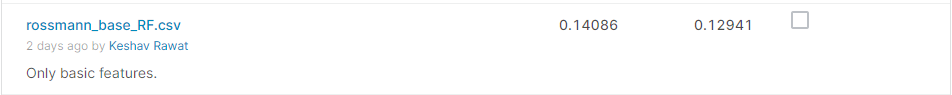

In [ ]:
Image('/content/drive/My Drive/Rossmann Sales Forecasting/Basic features score.png')

*Note: I will use above score to check the effects of new features being added or reomved.

# Models after selecting features using forward selection method.

In this section I have used features after doing forward selection on the above base model created. In forward selection we add a new feature and check whether it improves the performance or degrades it. The features which improve the performance are kept and others are discarded.

As the process is very lenghty and time consuming I have not included forward feature selection process here, and used the selected features directly.

In [ ]:
base_X = X[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'Customers_per_day', 'Sales_Per_Customers_Per_Day', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3','Acceleration','State','Promo_before_days',
            'Promo_after_days','Frequency_2', 'Frequency_3', 'Amplitude_2','Amplitude_3','Mean_TemperatureC','Events']]

y = df_1['Sales']

In [ ]:
base_df = pd.concat([base_X,y], axis=1)

In [ ]:
base_submit = df_submit[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'Customers_per_day', 'Sales_Per_Customers_Per_Day', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3','Acceleration','State','Promo_before_days', 
            'Promo_after_days','Frequency_2', 'Frequency_3', 'Amplitude_2','Amplitude_3','Mean_TemperatureC','Events']]

In [ ]:
cat_cols = ['StoreType','Assortment','StateHoliday','DayOfWeek','Promo','Year','Promo2','State','Events']
num_cols = [i for i in base_X.columns if i not in cat_cols]

num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                               ('cat',cat_transformer,cat_cols)])                                    

In [ ]:
# preprocessor.fit(base_X)
# pickle.dump(preprocessor, open('/content/drive/My Drive/Rossmann Sales Forecasting/preprocessor_base.pkl','wb'))

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imp',
                                                  IterativeImputer(add_indicator=False,
                                                                   estimator=None,
                                                                   imputation_order='ascending',
                                                                   initial_strategy='median',
                                                                   max_iter=10,
                                                                   max_value=None,
                                                                   min_value=None,
                                                                   missing_values=nan,
                                      

In [ ]:
preprocessor = pickle.load(open('/content/drive/My Drive/Rossmann Sales Forecasting/preprocessor_base.pkl','rb'))

In [ ]:
X_transformed = preprocessor.transform(base_X)
x_submit = preprocessor.transform(base_submit)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, shuffle=False, random_state=21, test_size=0.2)

## SGD Regressor.

In [ ]:
model = SGDRegressor(eta0=0.1,fit_intercept=False, shuffle=False,learning_rate='adaptive',random_state=21,)

model.fit(X_train, y_train)

train_preds = model.predict(X_train)
preds = model.predict(X_test)
preds

array([ 6735.38384189,  9017.67824655,  5248.60549971, ...,
        5990.3509813 , 12432.40525496, 21491.14049635])

In [ ]:
print(f'Metric score on train set is {rmspe(y_train, train_preds)}.')
print(f'Metric score on test set is {rmspe(y_test, preds)}.')

Metric score on train set is 0.299682946002019.
Metric score on test set is 0.25067387932230534.


In [ ]:
model.fit(X_transformed,y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=False, l1_ratio=0.15,
             learning_rate='adaptive', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=21,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
submit_preds = model.predict(x_submit)

In [ ]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = submit_preds * 0.983 # 0.983 is a correction factor.

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_sgd_selected_features.csv', index=False)

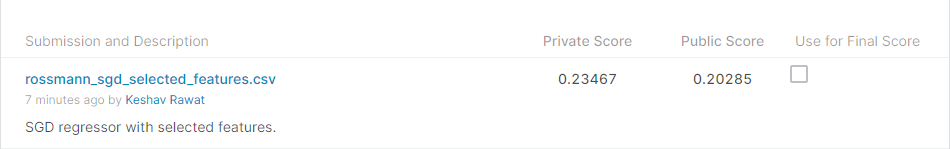

In [ ]:
Image('/content/drive/My Drive/Rossmann Sales Forecasting/sgd regressor with selected features.png')

## Decision Tree Regressor.


In [ ]:
model = DecisionTreeRegressor(splitter='random', max_depth=16, random_state=21)
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=16,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=21, splitter='random')

In [ ]:
train_preds = model.predict(X_train)
preds = model.predict(X_test)

print(f'Train score is {rmspe(y_train, train_preds)}.')
print(f'Test score is {rmspe(y_test, preds)}.')

Train score is 0.16730025064221918.
Test score is 0.17678558832884747.


In [ ]:
model.fit(X_transformed, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=16,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=21, splitter='random')

In [ ]:
submit_preds = model.predict(x_submit)
submit_preds

array([ 4078.        ,  5277.28813559,  8767.38647343, ...,
       11529.        ,  6025.        , 21911.11111111])

In [ ]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = submit_preds * 0.983 # 0.983 is a correction factor.

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_dt_selected_features.csv', index=False)

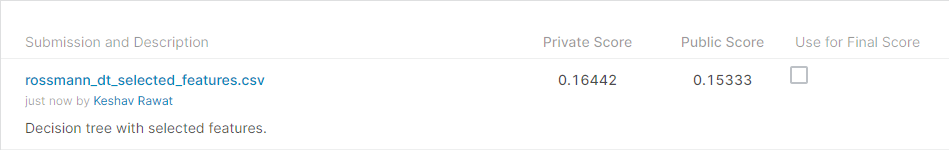

In [ ]:
Image('/content/drive/My Drive/Rossmann Sales Forecasting/dt selected features.png')

## Random Forest model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300, max_depth=17, n_jobs=-1, random_state=21)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [ ]:
train_preds = model.predict(X_train)
rmspe(y_train,train_preds)

0.14903796086841575

In [ ]:
preds = model.predict(X_test)
rmspe(y_test, preds)

0.16421245580976052

In [ ]:
model.fit(X_transformed, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [ ]:
preds = model.predict(x_submit)

In [ ]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  * 0.983 #Correction factor.

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_RF_with correction.csv', index=False)

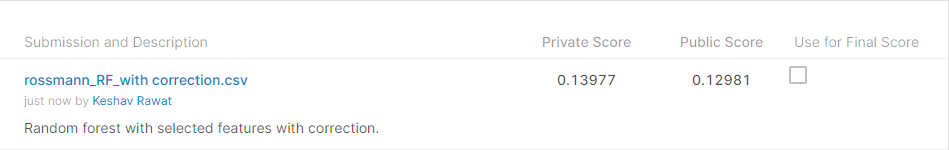

In [ ]:
Image('/content/drive/My Drive/Rossmann Sales Forecasting/rf model with selected features after correction.png')

## Light GBM model.

In [ ]:
#Training with best parameters.
base_lgb_model = lgb.LGBMRegressor(n_leaves=50,
                               n_estimators=700, 
                               max_depth=-1,  
                               learning_rate=0.3, #0.1
                               subsample=1,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=1)

base_lgb_model.fit(X_train, y_train)

train_preds = base_lgb_model.predict(X_train)
preds = base_lgb_model.predict(X_test)

In [ ]:
print(f'Metric score on train set is {rmspe(y_train, train_preds)}.')
print(f'Metric score on test set is {rmspe(y_test, preds)}.')

Metric score on train set is 0.16040787793729777.
Metric score on test set is 0.15714817228064962.


In [ ]:
base_lgb_model.fit(X_transformed,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, n_leaves=50, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.1, reg_lambda=1,
              silent=True, subsample=1, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
# joblib.dump(base_lgb_model, '/content/drive/My Drive/Rossmann Sales Forecasting/lgb_model.pkl')

['/content/drive/My Drive/Rossmann Sales Forecasting/lgb_model.pkl']

In [ ]:
preds = base_lgb_model.predict(x_submit)
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds * 0.983 #Correction factor.

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_lgb_selected_features.csv', index=False)

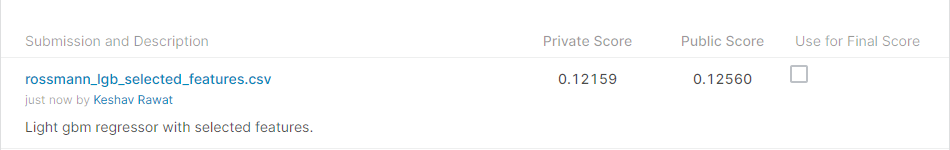

In [ ]:
Image('/content/drive/My Drive/Rossmann Sales Forecasting/lgb selected features..png')

## Meta Learning.

1. Divide data into 80-20 split.

2. Divide the train part into 2 parts, D1 and D2.

3. Take 9 samples from D1 and train Decision tree(shallow, medium and deep), Random Forest(shallow, medium and deep) and LightGBM(shallow, medium and deep).

4. Predict D2 from these 9 models. Use these 9 predictions as features and D2 y_original as output to train a new model.

5. Now for the test set, predict it using 9 models and using 9 predictions as features pass it to meta model. Use prediction from meta model as final prediction.

In [ ]:
#Splitting data into 80:20 ratio.
split = int(len(base_df) * 0.8)

dtrain = base_df[:split]
dtest = base_df[split:]

In [ ]:
def create_meta_model(n_estimators, dataset, fraction, preprocessor):
    '''
    This function will perform meta learning on the given dataset. It will return
    a final meta model which can be used to predict for future values. 
    -----------------------------------------------------------------------------
    n_estimators: No. of estimators to use while creating models on first half.

    dataset: Dataset on which to perform meta learning.

    fraction: Fraction of dataset to be used by the estimators.

    preprocessor: Pipeline to preprocess data such that data can be fed into a model.
    -----------------------------------------------------------------------------

    Here Random forest model will be used as a estimator. It's parameters will be
    chosen at random. 
    '''

    #Splitting train data into 2 equal parts.
    half = int(len(dataset) * 0.5)
    d1 = dataset[:half]
    d2 = dataset[half:]

    #Preparing d2 dataset.
    d2_x = d2.drop(['Sales'], axis=1)
    d2_x = preprocessor.transform(d2_x)
    d2_y = d2['Sales']

    #List to store samples.
    samples_list = []
    for i in range(n_estimators):
        new_sample = d1.sample(frac=fraction, random_state=21)
        new_sample.sort_values(['Year','Day'], inplace=True)
        samples_list.append(new_sample)
    
    #Dictionary to store predictions on d2 from every estimator.
    data_dict = dict()
    data_dict['output'] = d2_y

    #List to store models.
    models_list = []
    for i in range(len(samples_list)):
        #Preparing data to be fed into the model.
        x = samples_list[i].drop(['Sales'], axis=1)
        x = preprocessor.transform(x)
        y = samples_list[i]['Sales']

        model = RandomForestRegressor(n_estimators=200, max_depth=17, n_jobs=-1, random_state=21)
        model.fit(x,y)

        models_list.append(model)
        pred = model.predict(d2_x)

        #Adding prediction to data dictionary.
        data_dict[i] = pred

        print(f'{i+1} estimators done.')

    #Creating dataframe using the data_dict.
    meta_df = pd.DataFrame(data_dict)
    meta_x = meta_df.drop('output', axis=1)
    meta_y = meta_df['output']
    
    meta_model = RandomForestRegressor(n_jobs=-1, random_state=21, max_depth=20)
    meta_model.fit(meta_x.values, meta_y)

    return models_list, meta_model

def predict(models_list, meta_model, dataset):
    '''
    This model will give predictions ussing meta_model.
    ----------------------------------------------------
    models_list: List containing all the models used during meta learning.

    meta_model: Final model from meta learning.

    dataset: Preprocessed dataset to be used for prediction.

    preprocessor: Pipeline used during training to preprocess data.
    '''
    data_dict = dict()
    for i in range(len(models_list)):
        pred = models_list[i].predict(dataset)
        data_dict[i] = pred

    df = pd.DataFrame(data_dict)
    x = df.values

    preds = meta_model.predict(x)

    return preds

### Stacking with 9 models.

In [ ]:
models_list, meta_model = create_meta_model(9, dtrain, 0.5, preprocessor=preprocessor)

1 estimators done.
2 estimators done.
3 estimators done.
4 estimators done.
5 estimators done.
6 estimators done.
7 estimators done.
8 estimators done.
9 estimators done.


In [ ]:
x_train = preprocessor.transform(dtrain.drop('Sales', axis=1))
y_train = dtrain['Sales'] 

x_test = preprocessor.transform(dtest.drop('Sales', axis=1))
y_test = dtest['Sales']

preds = predict(models_list=models_list, meta_model=meta_model, dataset=x_test)
train_preds = predict(models_list=models_list, meta_model=meta_model, dataset=x_train)


print(f'Train rmspe is {rmspe(y_train, train_preds)}.')
print(f'Test rmspe is {rmspe(y_test, preds)}.')

Train rmspe is 0.1888758897276091.
Test rmspe is 0.19887634450872577.


In [ ]:
x_submit = preprocessor.transform(base_submit)

In [ ]:
submit_preds = predict(models_list=models_list, meta_model=meta_model, dataset=x_submit)

# Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = submit_preds * 0.983

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)

#Saving the result as a CSV file.
df_ypred[['Id', 'Sales']].to_csv('rossmann_stacked_9_selected_features.csv', index=False)

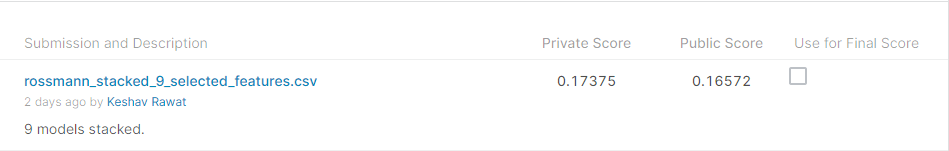

In [ ]:
Image('/content/drive/My Drive/Rossmann Sales Forecasting/stacked 9 model scores..png')

#Conclusions:

|Model | rmspe on test set | Kaggle private score|
|------|---------------------|--------------------|
|SGD Regressor|0.250|0.234
|Decision Tree Regressor|0.1767|0.16442
|Random Forest Regressor|0.164|0.139
|Light GBM Regressor|0.157|0.121
|Stacking with 9 models|0.1988|0.17375